# Primary Component Analysis

## Import packages

In [739]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## BGR to RGB converter

In [740]:
def convert_image(img):
    # enables mayplotlib to plot OpenCV images,
    # converts image from BGR to RGB
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return new_img

## Read and display image

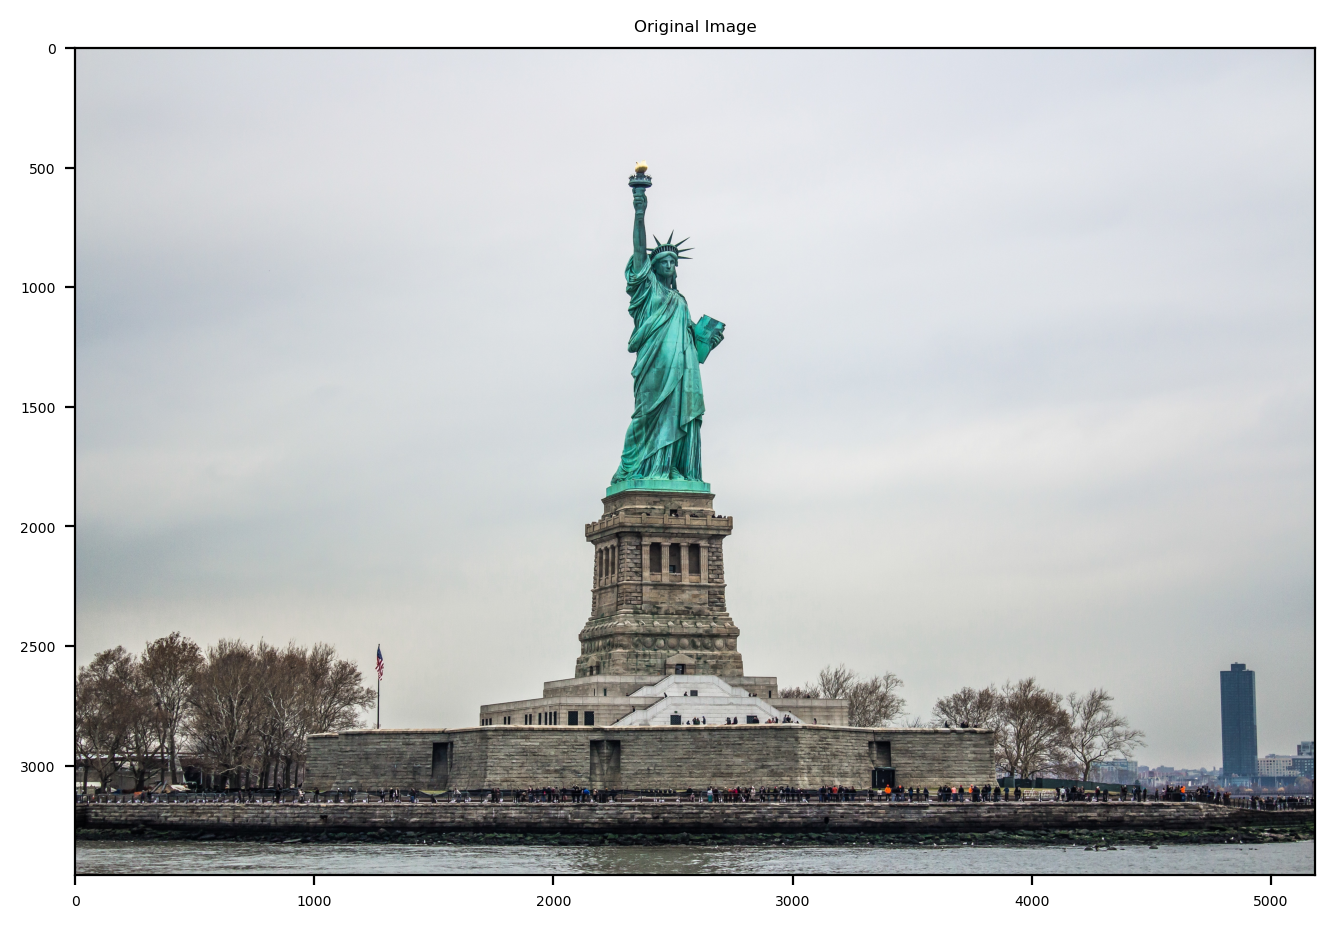

In [741]:
# read in image
img = cv2.imread("Images/liberty_original.jpg")

# display image
plt.rc('font', size=5)
plt.figure(figsize=(8, 8), dpi=200)
plt.title("Original Image")
plt.imshow(convert_image(img))
plt.show()

## Split image into 16x16 patches 

In [742]:
# split array into blocks of given dimension
def blockshaped(arr, nrows, ncols):
    h = arr.shape[0]
    w = arr.shape[1]
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

# separate color channels
B, G, R = cv2.split(img)

# split channels into 16x16 blocks
blue_patches = blockshaped(B,16,16)
green_patches = blockshaped(G,16,16)
red_patches = blockshaped(R,16,16)

## Vectorise each patch & find the mean and center of the patches

In [743]:
def find_center(patches):
    # vectorise patches
    flattened_patches = [patch.flatten() for patch in patches]

    # find the mean
    img_mean = np.mean(flattened_patches, axis=0)

    # center of gravity of the points
    center = flattened_patches - img_mean
    return center, img_mean

## Find the covariance matrix and the eigenvectors & eigenvalues

In [744]:
def find_eigens(center):
    # find the covariance matrix
    covariance_matrix = np.cov(center.T)

    # find eigenvectors & eigenvalues
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues from highest to lowest
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]

    # sort eigenvectors from one associated with the highest eigenvalue to the one associated with the lowest
    eigen_vectors = eigen_vectors[:,idx]
    return eigen_vectors, eigen_values

## Reconstruct image

In [745]:
# reconstruct the given patch against k principal components
# reconstructed = PCA_score.eigenvectors.T - mean
def reconstruct(k, patch, eigen_vectors, mean):
    vectors = (eigen_vectors[:,:k])
    vectors_transpose = vectors.T
    pca_scores = np.matmul(patch, vectors)
    pdv = np.matmul(pca_scores, vectors_transpose)
    rec = pdv + mean
    return rec

def restore(k, center, img, eigen_vectors, mean, colour):
    # store reconstructed patches
    rec_patches = []

    # send centered patches to reconstruct method
    for i in range(0, center.shape[0]):
        p = reconstruct(k, center[i,:], eigen_vectors, mean)
        p = p.reshape(16,16)
        rec_patches.append(p)
    rec_patches = np.array(rec_patches)

    # empty array the size of original image
    recImg = np.zeros((img.shape[0], img.shape[1]))

    # piece reconstructed patches into image
    counter = 0
    for i in range(0, img.shape[0], 16):
                for j in range(0, img.shape[1], 16):
                    patch = rec_patches[counter]
                    recImg[i:i + 16, j:j + 16] = patch
                    counter += 1
                    
    # merge image with black channels           
    k = np.zeros_like(recImg)                 
    if colour == "Red":
        col_image = cv2.merge([recImg,k,k])
    elif colour == "Green":
        col_image = cv2.merge([k,recImg,k])
    elif colour == "Blue":
        col_image = cv2.merge([k,k,recImg])


    # display channel image
    plt.rc('font', size=5)
    plt.figure(figsize=(2, 2), dpi=200)
    plt.title("Reconstructed Image - %s Channel" %colour)
    plt.imshow(col_image.astype('uint8'))
    plt.show()
    
    return recImg


## PCA Runner

In [746]:
eigen_vecs = 0
eigen_vals = 0

def run_PCA(k, store=True):

    # conduct PCA and restoration on blue channel
    b_center, b_mean = find_center(blue_patches)
    b_vectors, b_values = find_eigens(b_center)
    blue = restore(k, b_center, img, b_vectors, b_mean, "Blue")

    # conduct PCA and restoration on green channel
    g_center, g_mean = find_center(green_patches)
    g_vectors, g_values = find_eigens(g_center)
    green = restore(k, g_center, img, g_vectors, g_mean, "Green")

    # conduct PCA and restoration on red channel
    r_center, r_mean = find_center(red_patches)
    r_vectors, r_values = find_eigens(r_center)
    red = restore(k, r_center, img, r_vectors, r_mean, "Red")

    # merge channels together to get restored image
    final_image = cv2.merge((blue, green, red))
    final_image = final_image.astype('uint8')
    
    # store eigevectors and eigenvalues to use later
    if store:
        global eigen_vecs
        eigen_vecs = b_vectors
        global eigen_vals
        eigen_vals = b_values
    
    return final_image

## Reconstruction for K=10

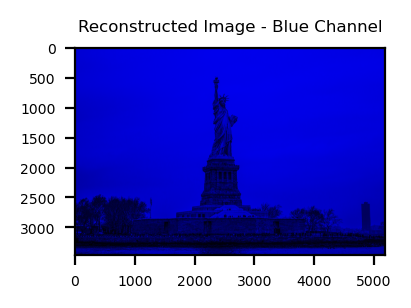

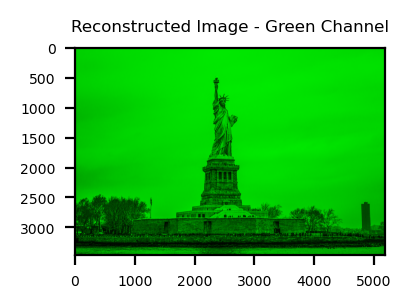

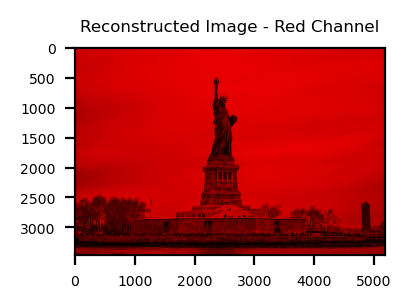

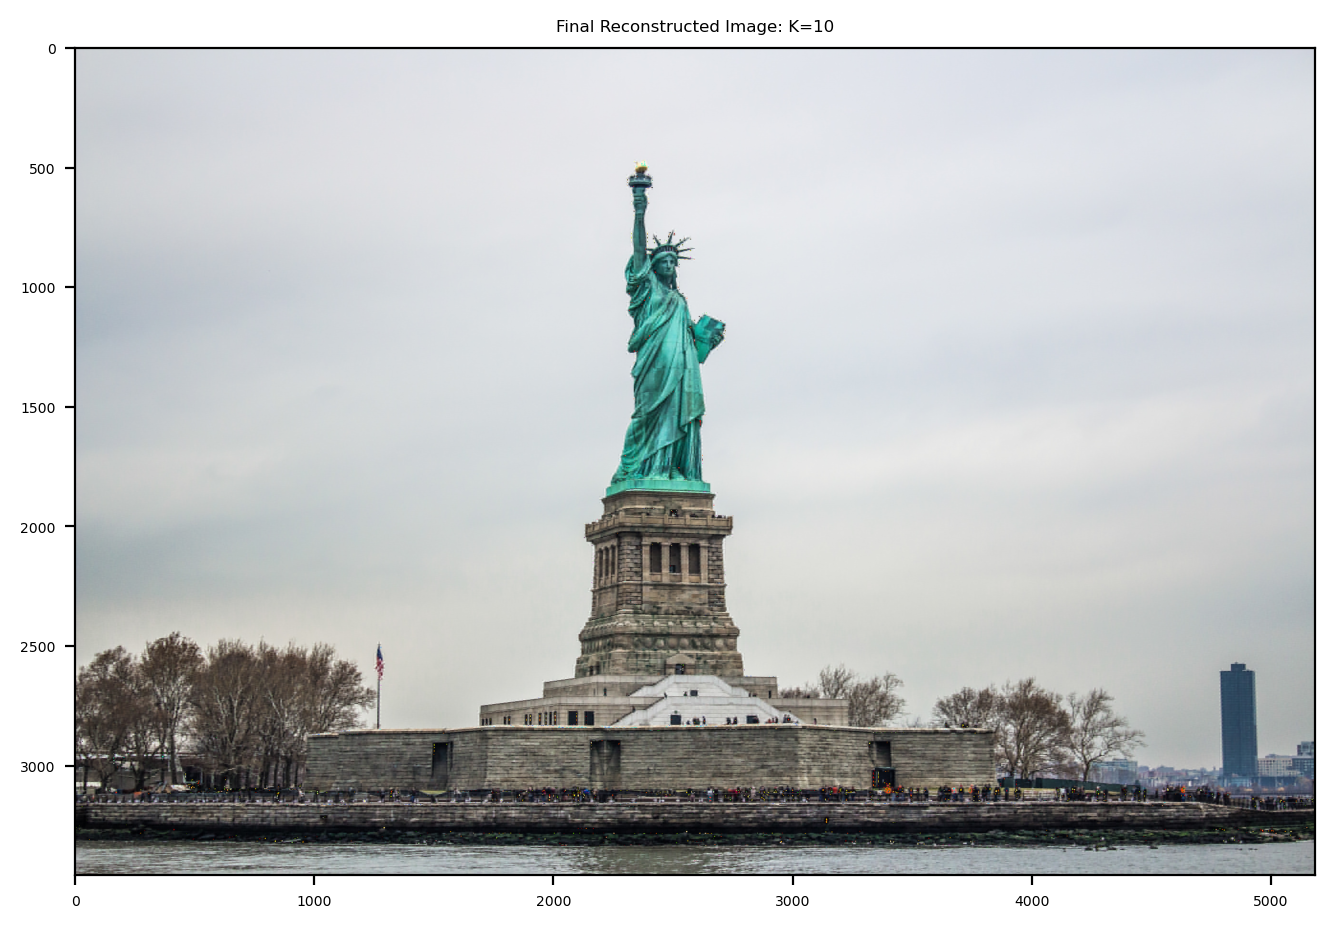

In [747]:
# conduct PCA and reconstruction with 10 principal components
img10 = run_PCA(10)

# display reconstructed image
plt.rc('font', size=5)
plt.figure(figsize=(8, 8), dpi=200)
plt.title("Final Reconstructed Image: K=10")
plt.imshow(convert_image(img10))
plt.show()

## Reconstruction for K=100

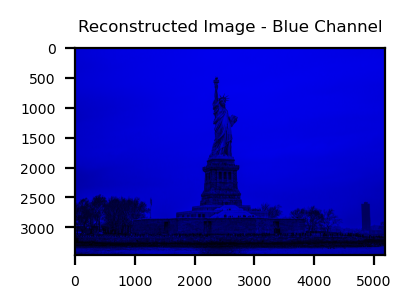

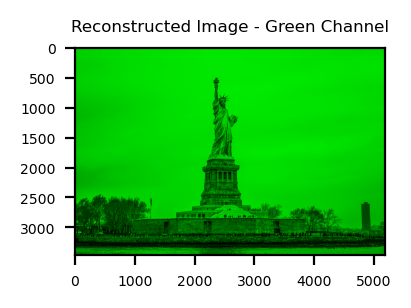

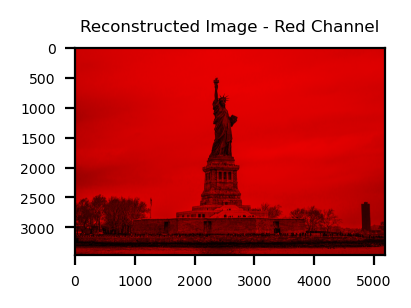

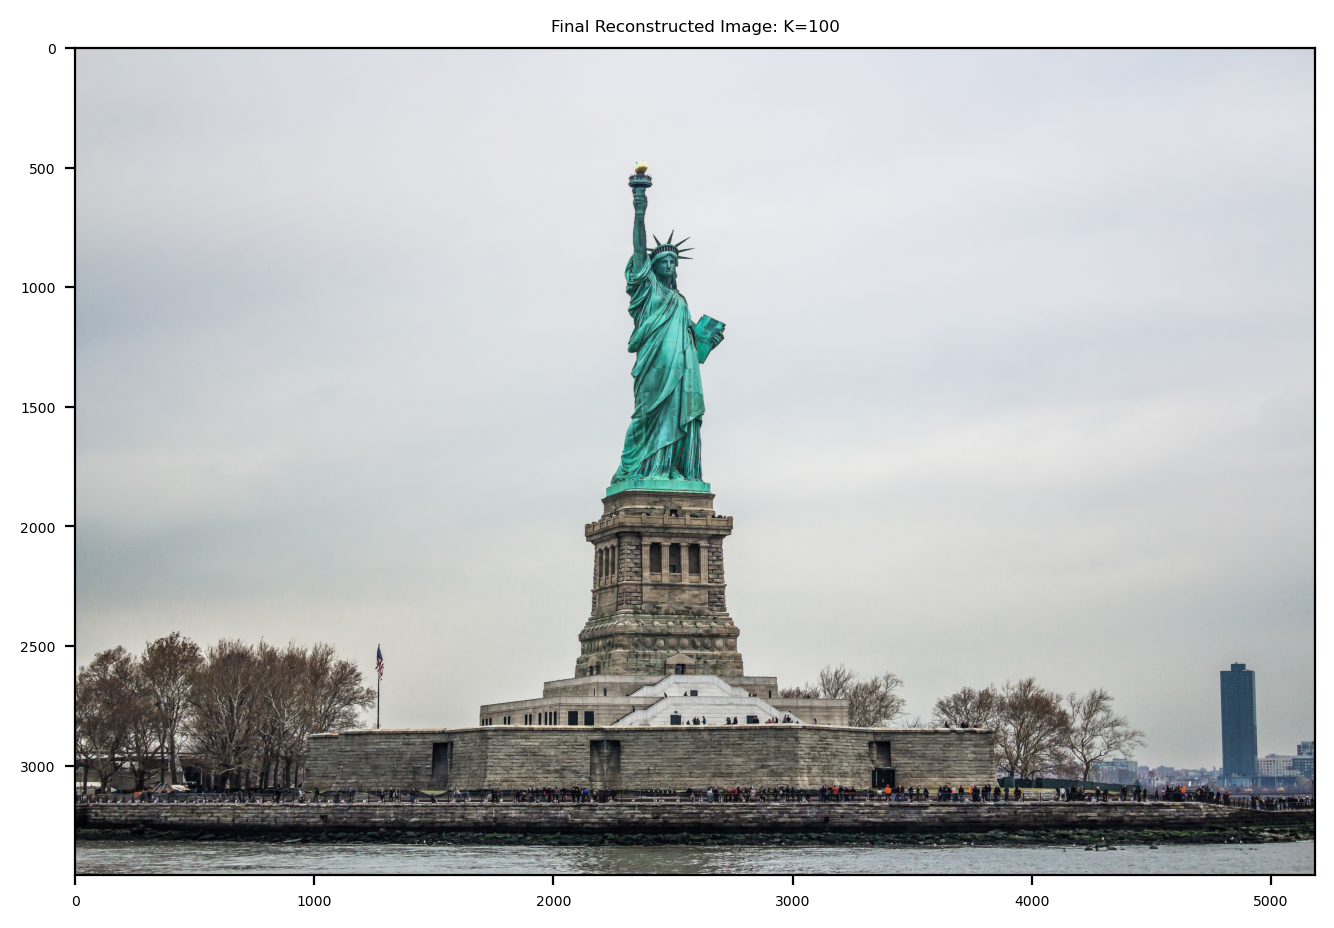

In [748]:
# conduct PCA and reconstruction with 100 principal components
img100 = run_PCA(100, store=False)

# display reconstructed image
plt.rc('font', size=5)
plt.figure(figsize=(8, 8), dpi=200)
plt.title("Final Reconstructed Image: K=100")
plt.imshow(convert_image(img100))
plt.show()

## Store images as PNG

In [749]:
cv2.imwrite("Images/Reconstruct_K10.png", img10)
cv2.imwrite("Images/Reconstruct_K100.png", img100)
cv2.waitKey(0)

-1

## First 10 principal components

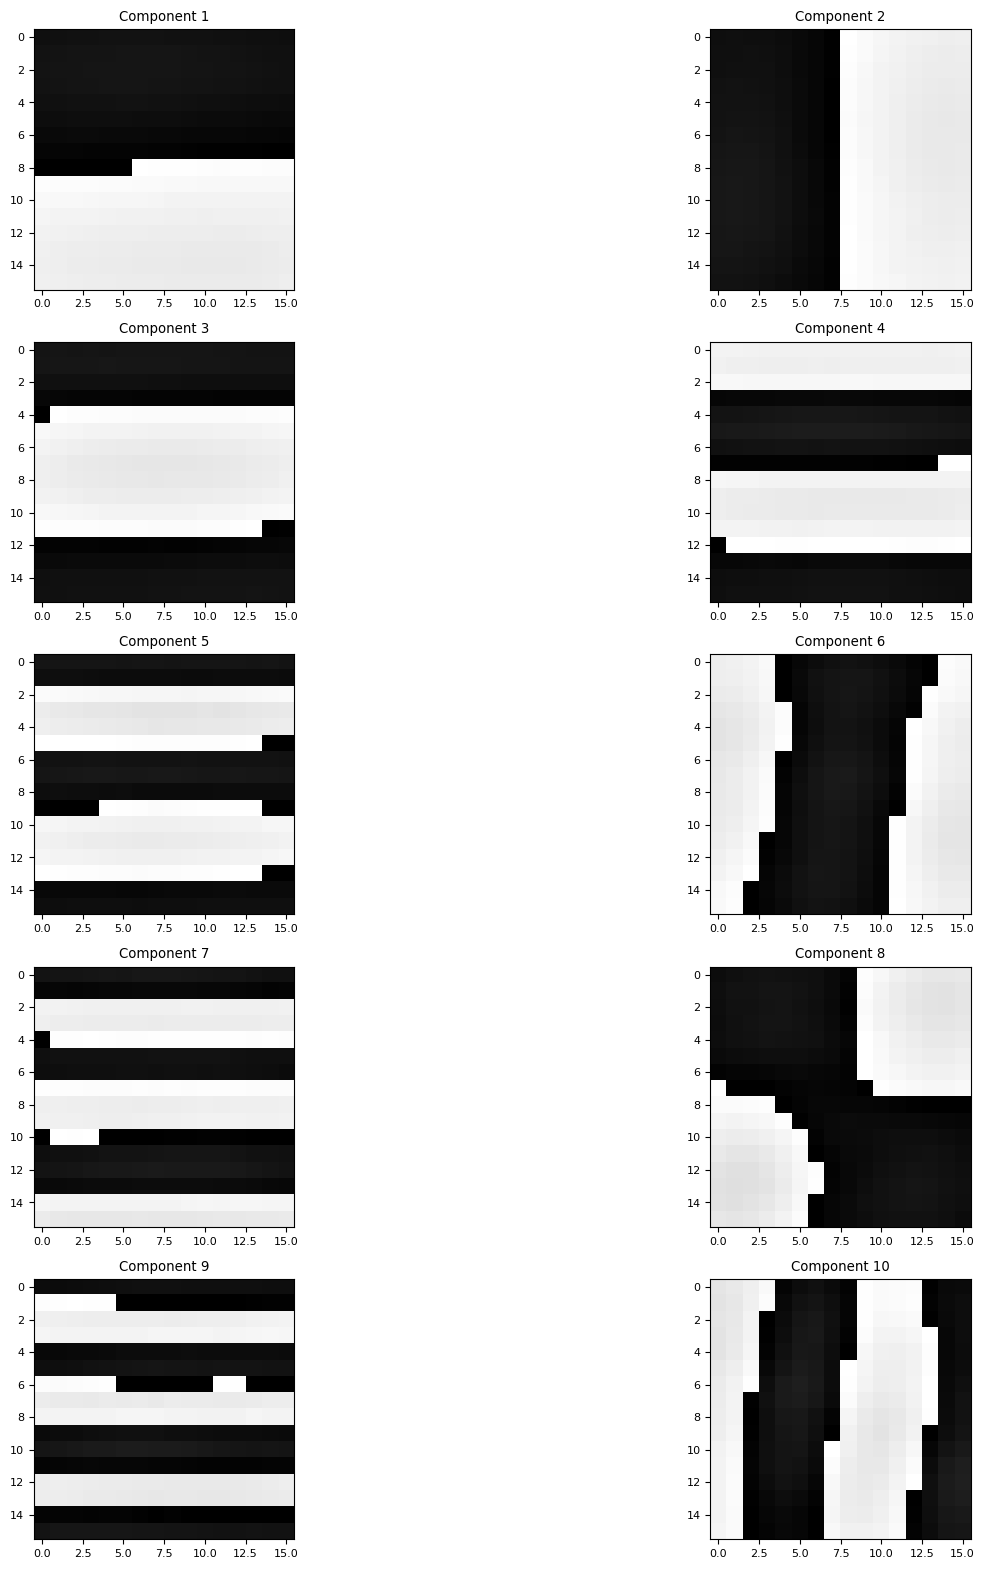

In [750]:
plt.rc('font', size=8)
fig=plt.figure(figsize=(16, 20), dpi=100)

# Take first 10 ordered eigenvectors(components) and plot
columns = 2
rows = 5
for i in range(1, columns*rows +1):
    im = eigen_vecs[:,i].reshape(16,16)
    im = im.astype(np.float64)
    im=im*255
    im=im.astype(np.uint8)
    cv2.imwrite("Images/Component_%s.png"%i, im)
    fig.add_subplot(rows, columns, i)
    plt.title("Component %s"%i)
    plt.imshow(im, cmap='gray')
plt.show()

## Optimising K selection

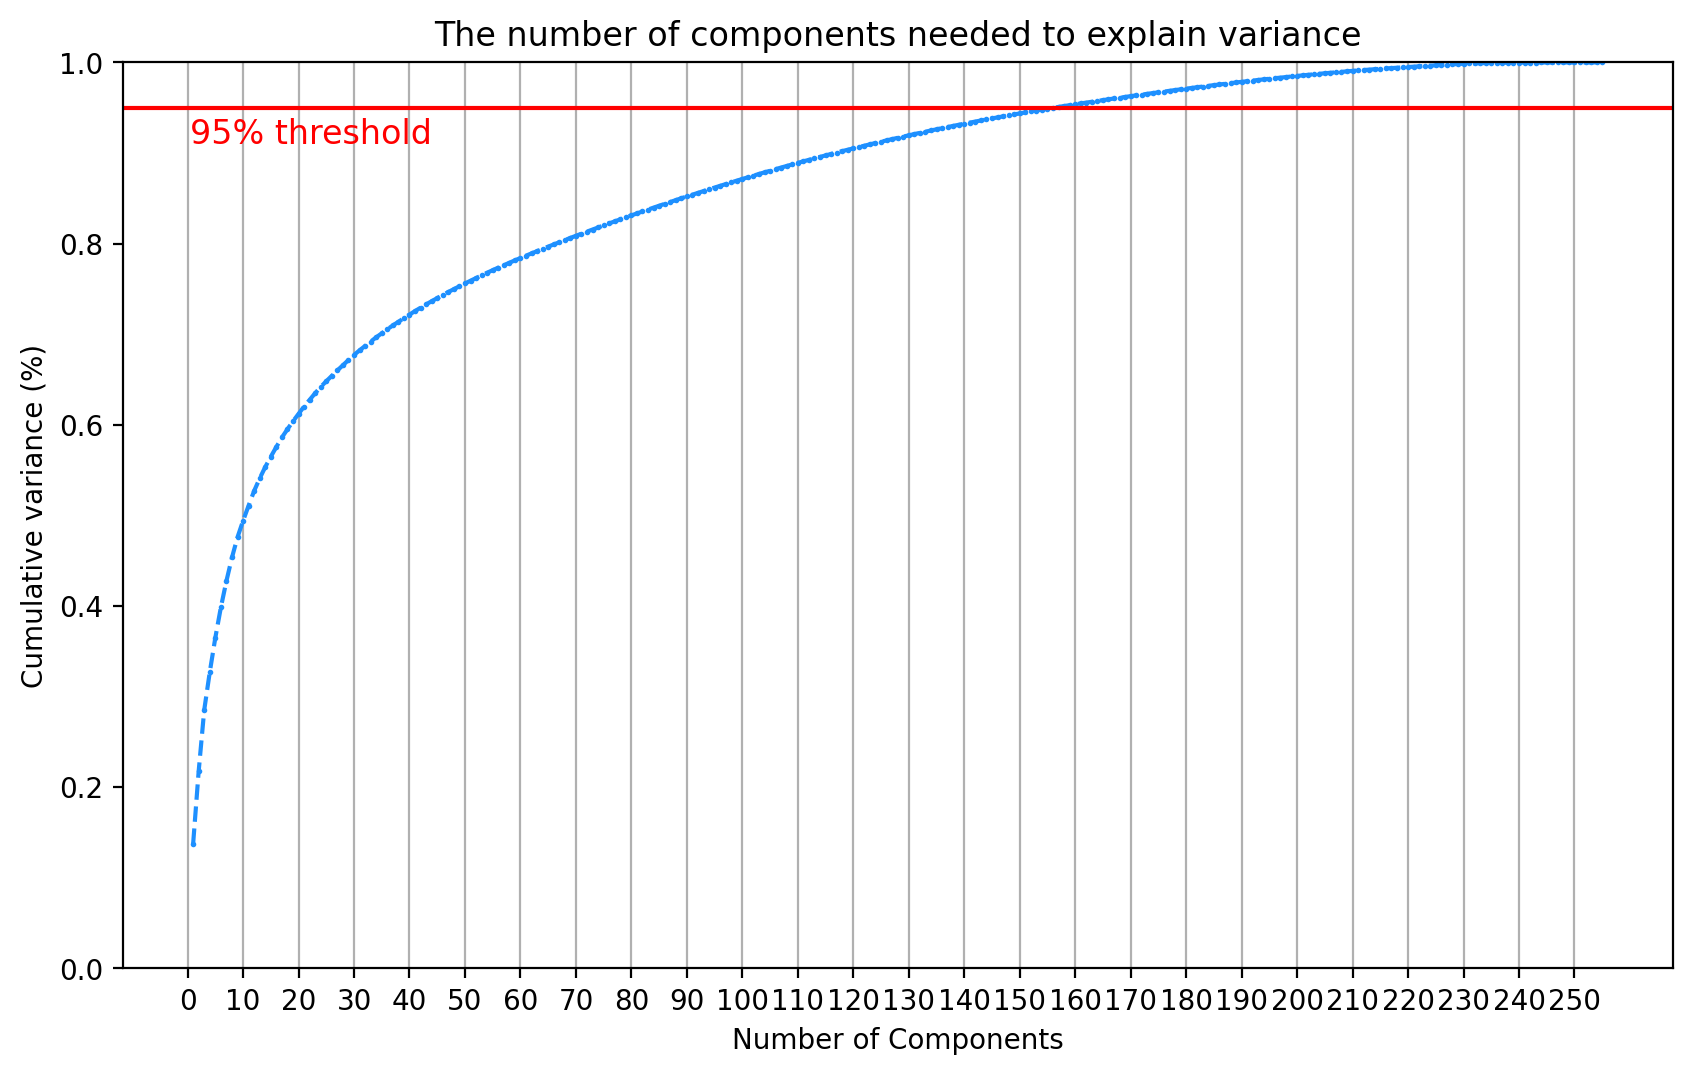

In [751]:
eigen_vals = np.delete(eigen_vals, 0)

# total variance for components
total_variance = np.sum(eigen_vals)

# find variance ratio for each component (variance/total variance)
var_ratios = []
for i in range(0,len(eigen_vals)):
    var_i = eigen_vals[i]/total_variance
    var_ratios.append(var_i)

# cumulative variances
y = np.cumsum(var_ratios)

# num components
xi = np.arange(1, len(eigen_vals)+1, step=1)

# display plot
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
plt.ylim(0,1)
plt.plot(xi, y, marker='o', markersize=1, linestyle='--', color='dodgerblue')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(eigen_vals), step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='red', linestyle='-')
plt.text(0.5, 0.91, '95% threshold', color = 'red', fontsize=12)

ax.grid(axis='x')
plt.show()

## PCA and reconstruction using 160 principal components 

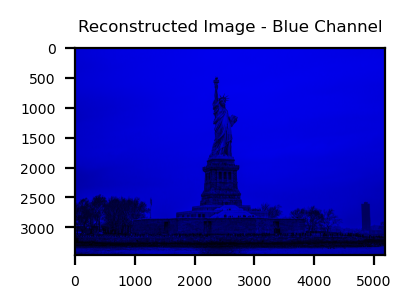

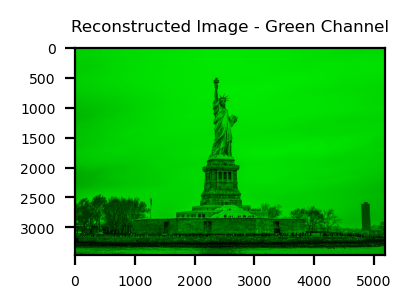

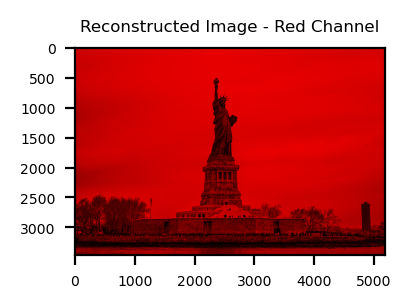

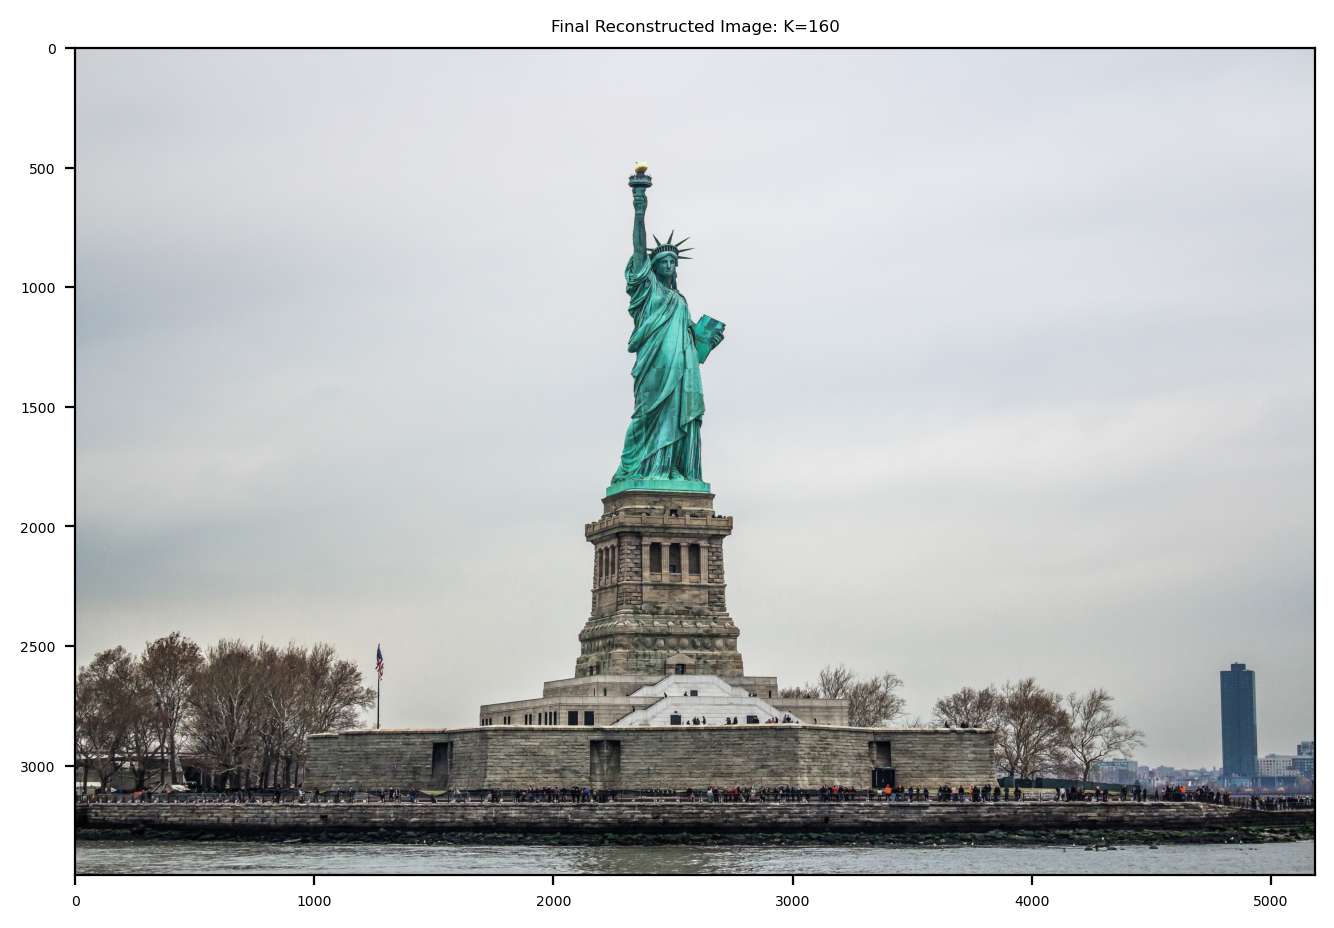

-1

In [752]:
# conduct PCA and reconstruction with 160 principal components
opt_img = run_PCA(160, store=False)

# display reconstructed image
plt.rc('font', size=5)
plt.figure(figsize=(8, 8), dpi=200)
plt.title("Final Reconstructed Image: K=160")
plt.imshow(convert_image(opt_img))
plt.show()

# save image 
cv2.imwrite("Images/Reconstruct_K160.png", opt_img)
cv2.waitKey(0)